# Packages

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tensorflow.keras.utils import image_dataset_from_directory

# Loading the Data

\=================================================================================================================\
I have used the data at this link: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
\=================================================================================================================

In [ ]:
!unzip drive/MyDrive/dataset.zip

\=================================================================================================================\
Firstly, we need to look at the size of the images. We will take the average image size and pass it to the function "image_dataset_from_directory" as an argument.
\=================================================================================================================

In [4]:
images = []
for img in glob.iglob("dataset/*/*"):
  img = Image.open(img)
  images.append(np.asarray(img))
images = np.asarray(images, dtype="object")

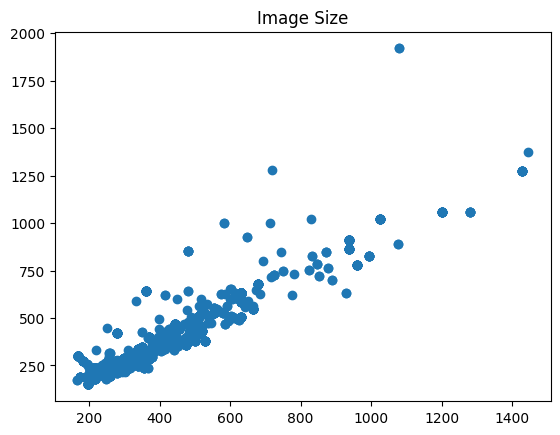

In [5]:
X = []
Y = []
for i in range(images.shape[0]):
  X.append(images[i].shape[0])
  Y.append(images[i].shape[1])
X = np.asarray(X)
Y = np.asarray(Y)

plt.scatter(X, Y)
plt.title("Image Size")
plt.show()

In [6]:
avg_X = np.mean(X).astype("int32")
avg_Y = np.mean(Y).astype("int32")
image_size = (avg_X, avg_Y)
image_size

(378, 359)

In [7]:
train = image_dataset_from_directory(
    "dataset/",
    labels="inferred",
    image_size=image_size,
    color_mode="rgb",
    shuffle=True,
    batch_size=32,
    validation_split=0.3,
    subset="training",
    seed=16
)

dev = image_dataset_from_directory(
    "dataset/",
    labels="inferred",
    image_size=image_size,
    color_mode="rgb",
    shuffle=True,
    batch_size=32,
    validation_split=0.3,
    subset="validation",
    seed=16
)

Found 4514 files belonging to 2 classes.
Using 3160 files for training.
Found 4514 files belonging to 2 classes.
Using 1354 files for validation.


In [8]:
classes = train.class_names
classes

['Brain Tumor', 'Healthy']

# Data Visualization

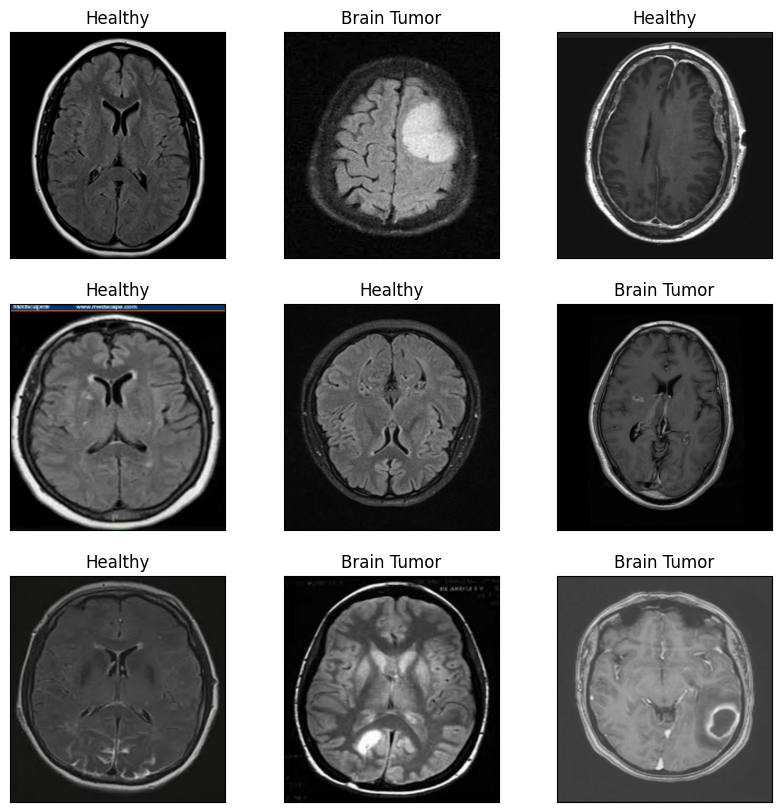

In [ ]:
for images, labels in train.take(1):
    figs, axs = plt.subplots(3, 3, figsize=(10,10))
    for i in range(3):
        temp = 3*i
        for j in range(3):
            index = temp + j
            axs[i][j].imshow(images[index].numpy().astype("int32"))
            axs[i][j].set_title(classes[labels[index]])
            axs[i][j].set_xticks(ticks=[])
            axs[i][j].set_yticks(ticks=[])

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train = tf.data.Dataset.prefetch(train, buffer_size=AUTOTUNE)
dev = tf.data.Dataset.prefetch(dev, buffer_size=AUTOTUNE)

# Model
\=================================================================================================================\
We are going to apply transfer learning with VGG16 model.\
\=================================================================================================================

In [10]:
image_shape = image_size + (3,)

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights="imagenet",
                                               input_shape=image_shape)
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 378, 359, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 378, 359, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 378, 359, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 189, 179, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 189, 179, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 189, 179, 128)     147584    
                                                              

In [ ]:
def tumor_classifier(input_shape):
    base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                   weights="imagenet",
                                                   input_shape=input_shape)
    base_model.trainable = False

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = tumor_classifier(input_shape=image_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 378, 359, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 378, 359, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 378, 359, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 378, 359, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 11, 11, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 61952)             0     

# Training

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

epochs = 10
history = model.fit(train, batch_size=32, validation_data=dev, epochs=epochs)

Epoch 1/10
113/113 [==============================] - 83s 589ms/step - loss: 0.7051 - accuracy: 0.6262 - val_loss: 0.5879 - val_accuracy: 0.6840
Epoch 2/10
113/113 [==============================] - 51s 449ms/step - loss: 0.6040 - accuracy: 0.6700 - val_loss: 0.5992 - val_accuracy: 0.7173
Epoch 3/10
113/113 [==============================] - 51s 450ms/step - loss: 0.5622 - accuracy: 0.6974 - val_loss: 0.6062 - val_accuracy: 0.6585
Epoch 4/10
113/113 [==============================] - 52s 454ms/step - loss: 0.5521 - accuracy: 0.6949 - val_loss: 0.5717 - val_accuracy: 0.7583
Epoch 5/10
113/113 [==============================] - 52s 450ms/step - loss: 0.5142 - accuracy: 0.7140 - val_loss: 0.5120 - val_accuracy: 0.6885
Epoch 6/10
113/113 [==============================] - 51s 449ms/step - loss: 0.5468 - accuracy: 0.7004 - val_loss: 0.5379 - val_accuracy: 0.7749
Epoch 7/10
113/113 [==============================] - 51s 450ms/step - loss: 0.5085 - accuracy: 0.7237 - val_loss: 0.5051 - val_ac

# Fine Tuning

\=================================================================================================================\
As one can see, we obtained the training accuracy 74%. To further increase the accuracy, we will unfreeze some later layers of the model. Also, we may add some additional layers. We will try and see it.\
\=================================================================================================================

In [ ]:
len(base_model.layers)

19

In [ ]:
def fine_tuned_model(input_shape, num_freezed_layers):
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                   weights="imagenet",
                                                   include_top=False)
    base_model.trainable = True
    for layer in base_model.layers[:num_freezed_layers]:
        layer.trainable = False

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    x = base_model(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
num_freezed_layers = 7
model = fine_tuned_model(input_shape=image_shape, num_freezed_layers=num_freezed_layers)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 378, 359, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 378, 359, 3)       0         
                                                                 
 tf.__operators__.getitem_3  (None, 378, 359, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 378, 359, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 11, 11, 512)       14714688  
                                                                 
 conv2d_15 (Conv2D)          (None, 11, 11, 1024)      4719

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

epochs = 10
history = model.fit(train, batch_size=32, validation_data=dev, epochs=epochs)

Epoch 1/10
113/113 [==============================] - 118s 1s/step - loss: 2.3968 - accuracy: 0.5044 - val_loss: 19.8700 - val_accuracy: 0.4623
Epoch 2/10
113/113 [==============================] - 98s 861ms/step - loss: 0.8477 - accuracy: 0.5916 - val_loss: 27.1919 - val_accuracy: 0.4623
Epoch 3/10
113/113 [==============================] - 97s 859ms/step - loss: 0.6822 - accuracy: 0.6841 - val_loss: 7.6178 - val_accuracy: 0.4623
Epoch 4/10
113/113 [==============================] - 97s 859ms/step - loss: 0.6745 - accuracy: 0.6863 - val_loss: 10.4428 - val_accuracy: 0.5377
Epoch 5/10
113/113 [==============================] - 210s 2s/step - loss: 0.6993 - accuracy: 0.6913 - val_loss: 10.9576 - val_accuracy: 0.4623
Epoch 6/10
113/113 [==============================] - 97s 856ms/step - loss: 0.5908 - accuracy: 0.7403 - val_loss: 12.4277 - val_accuracy: 0.5377
Epoch 7/10
113/113 [==============================] - 98s 861ms/step - loss: 0.5161 - accuracy: 0.7674 - val_loss: 11.6639 - val_

In [ ]:
epochs = 20
history2 = model.fit(train, batch_size=32, validation_data=dev, epochs=epochs, initial_epoch=history.epoch[-1])

Epoch 10/20
113/113 [==============================] - 98s 864ms/step - loss: 0.3681 - accuracy: 0.8463 - val_loss: 8.9046 - val_accuracy: 0.5377
Epoch 11/20
113/113 [==============================] - 98s 861ms/step - loss: 0.3664 - accuracy: 0.8569 - val_loss: 5.8648 - val_accuracy: 0.4634
Epoch 12/20
113/113 [==============================] - 98s 861ms/step - loss: 0.5892 - accuracy: 0.8137 - val_loss: 5.9820 - val_accuracy: 0.4690
Epoch 13/20
113/113 [==============================] - 97s 855ms/step - loss: 0.3075 - accuracy: 0.8768 - val_loss: 4.2232 - val_accuracy: 0.4823
Epoch 14/20
113/113 [==============================] - 97s 858ms/step - loss: 0.2634 - accuracy: 0.8981 - val_loss: 7.5688 - val_accuracy: 0.5377
Epoch 15/20
113/113 [==============================] - 97s 856ms/step - loss: 0.2440 - accuracy: 0.9025 - val_loss: 1.2415 - val_accuracy: 0.6508
Epoch 16/20
113/113 [==============================] - 97s 858ms/step - loss: 0.1981 - accuracy: 0.9214 - val_loss: 0.5688 -

# Error Analysis

([<matplotlib.axis.XTick at 0x7c804c97d360>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

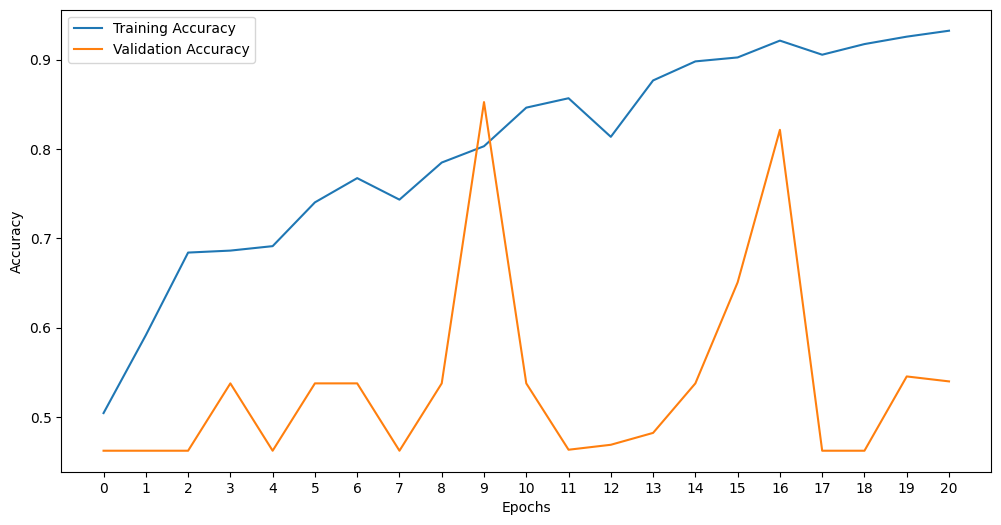

In [ ]:
acc = history.history["accuracy"] + history2.history["accuracy"]
val_acc = history.history["val_accuracy"] + history2.history["val_accuracy"]

plt.figure(figsize=(12,6))
plt.plot(range(epochs+1), acc, label="Training Accuracy")
plt.plot(range(epochs+1), val_acc, label="Validation Accuracy")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(list(range(epochs+1)))

\=================================================================================================================\
As one can clearly see from the plot above, there is a high variance, i.e, overfitting. To deal with this, we will apply data augmentation and regularization.\
\=================================================================================================================

# Data Augmentation and Regularization

In [11]:
def augment_data(input):
    x = tf.keras.layers.RandomFlip("horizontal")(input)
    output = tf.keras.layers.RandomRotation(0.1)(x)

    return output

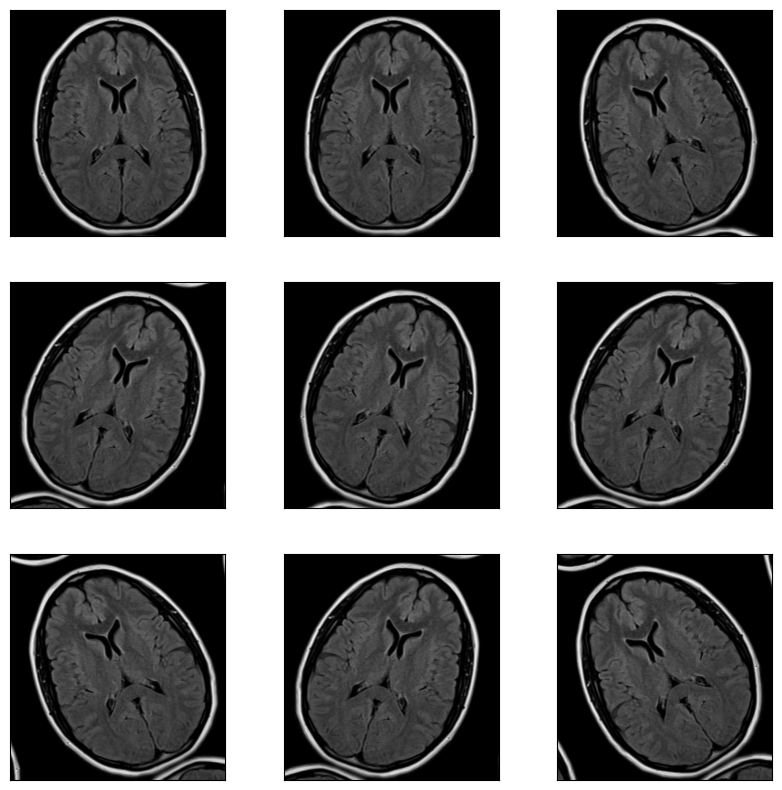

In [ ]:
for images, labels in train.take(1):
    img = images[0]
    figs, axs = plt.subplots(3, 3, figsize=(10,10))
    for i in range(3):
        for j in range(3):
            augmented_img = augment_data(img)
            axs[i][j].imshow(augmented_img.numpy().astype("int32"))
            axs[i][j].set_xticks(ticks=[])
            axs[i][j].set_yticks(ticks=[])

In [ ]:
def data_augmented_regularized_model(input_shape, num_freezed_layers):
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    base_model.trainable = True
    for layer in base_model.layers[:num_freezed_layers]:
      layer.trainable = False

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = augment_data(inputs)
    x = tf.keras.layers.Rescaling(1./255)(x)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    x = base_model(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding="same", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
num_freezed_layers = 7
model = data_augmented_regularized_model(input_shape=image_shape, num_freezed_layers=num_freezed_layers)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

epochs = 30
history = model.fit(train, batch_size=32, validation_data=dev, epochs=epochs)

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/30
99/99 [==============================] - 172s 1s/step - loss: 2.3356 - accuracy: 0.4994 - val_loss: 4.2551 - val_accuracy: 0.4586
Epoch 2/30
99/99 [==============================] - 107s 1s/step - loss: 1.3173 - accuracy: 0.5123 - val_loss: 0.9329 - val_accuracy: 0.4594
Epoch 3/30
99/99 [==============================] - 107s 1s/step - loss: 0.8617 - accuracy: 0.5573 - val_loss: 0.8736 - val_accuracy: 0.5613
Epoch 4/30
99/99 [==============================] - 102s 1s/step - loss: 0.9244 - accuracy: 0.5766 - val_loss: 2.6524 - val_accuracy: 0.4586
Epoch 5/30
99/99 [==============================] - 107s 1s/step - loss: 0.7789 - accuracy: 0.6196 - val_loss: 8.0098 - val_accuracy: 0.4586
Epoch 6/30
99/99 [==============================] - 103s 1s/step - loss: 0.7621 - accuracy: 0.6168 - val_loss: 91.2655 - val_accuracy: 0.5414
Epoch 7/30
99/99 [==============================] - 102s 1s/step - loss: 0.6998 - accura

\=================================================================================================================\
Apparently, validation accuracy does not increase by adding regularization and data augmentation. Also, we have a limited amount of data and we can not increase it. The only option left is, simplifying the model. According to the results, the VGG16 model has too many layers for the task. So, we will build a new model from scratch with fewer layers.\
\=================================================================================================================

In [21]:
def final_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = augment_data(x)
    x = tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [22]:
model = final_model(input_shape=image_shape)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 378, 359, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 378, 359, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 378, 359, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 378, 359, 3)       0         
 ation)                                                          
                                                                 
 conv2d_15 (Conv2D)          (None, 378, 359, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 189, 179, 16)      0         
 ng2D)                                                     

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

epochs = 20
history = model.fit(train, batch_size=32, validation_data=dev, epochs=epochs)

Epoch 1/20
99/99 [==============================] - 22s 181ms/step - loss: 0.6653 - accuracy: 0.6123 - val_loss: 0.5706 - val_accuracy: 0.6883
Epoch 2/20
99/99 [==============================] - 18s 176ms/step - loss: 0.5573 - accuracy: 0.6918 - val_loss: 0.4469 - val_accuracy: 0.7422
Epoch 3/20
99/99 [==============================] - 19s 183ms/step - loss: 0.4312 - accuracy: 0.7782 - val_loss: 0.3588 - val_accuracy: 0.8058
Epoch 4/20
99/99 [==============================] - 18s 173ms/step - loss: 0.3528 - accuracy: 0.8329 - val_loss: 0.3643 - val_accuracy: 0.7991
Epoch 5/20
99/99 [==============================] - 18s 176ms/step - loss: 0.3098 - accuracy: 0.8560 - val_loss: 0.2644 - val_accuracy: 0.8612
Epoch 6/20
99/99 [==============================] - 19s 184ms/step - loss: 0.2637 - accuracy: 0.8826 - val_loss: 0.2452 - val_accuracy: 0.8848
Epoch 7/20
99/99 [==============================] - 18s 181ms/step - loss: 0.2350 - accuracy: 0.8908 - val_loss: 0.2381 - val_accuracy: 0.8826

# Visualizing Results

Text(0, 0.5, 'Loss')

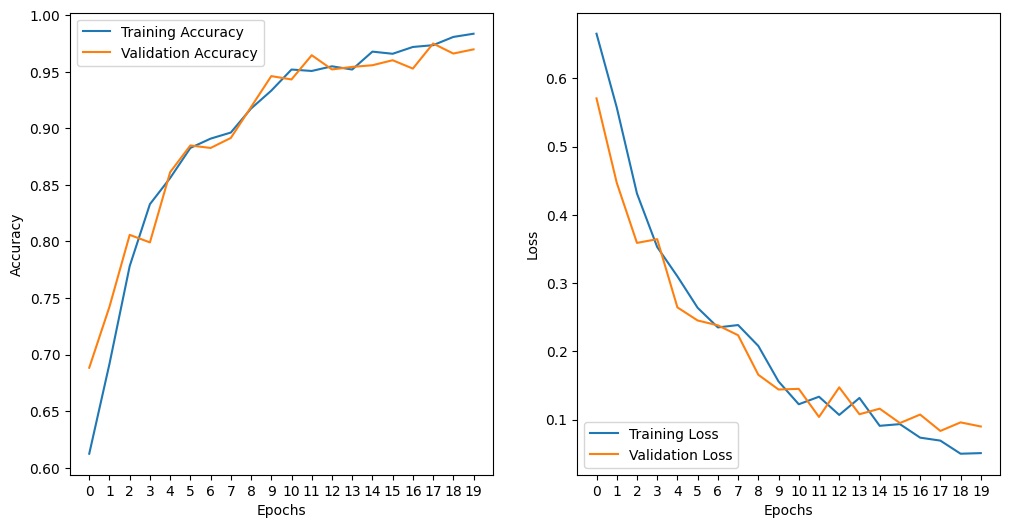

In [27]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

figs, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].plot(range(epochs), acc, label="Training Accuracy")
axs[0].plot(range(epochs), val_acc, label="Validation Accuracy")
axs[0].legend(loc="upper left")
axs[0].set_xlabel("Epochs")
axs[0].set_xticks(list(range(epochs)))
axs[0].set_ylabel("Accuracy")
axs[1].plot(range(epochs), loss, label="Training Loss")
axs[1].plot(range(epochs), val_loss, label="Validation Loss")
axs[1].legend(loc="lower left")
axs[1].set_xlabel("Epochs")
axs[1].set_xticks(list(range(epochs)))
axs[1].set_ylabel("Loss")

# Prediction on New Data

In [46]:
img = tf.keras.utils.load_img("tumor.jpeg", target_size=image_size)
img = np.asarray(img)
img = tf.expand_dims(img, 0)

prediction = model.predict(img)
score = tf.math.sigmoid(prediction)
result = 1 if score > 0.5 else 0
confidence = float(score * 100) if result else float((1-score) * 100)
print(f"The image belongs to class '{classes[result]}' with {confidence:.4f}% confidence.")

1/1 [==============================] - 0s 28ms/step
The image belongs to class 'Brain Tumor' with 99.9962% confidence.


# Saving the Model

In [47]:
model.save("brain_tumor_classifier.keras")